# Prepare data
## Import

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted

# Data cleaning

In [64]:
def wrangle (filepath,location):
 df = pd.read_csv(filepath)

# subset to apartments
 mask_apt = df["propertyType"]== "Apartment"

#subset properties in westlands
 mask_wl = df["Location"].str.contains(location, case = False)

 df = df[mask_apt & mask_wl]
# remove null values
 df = df.dropna(subset=["Price","House size"])

# Clean price col
 df["Price"] = df["Price"].str.replace('KSh', '', regex= False).str.replace(' ', '', regex = False).astype(int)

# clean House size col
 df["House size"] = df["House size"].str.replace('m²','', regex= False).str.replace(' ', '', regex = False).astype(int)
 
# Removing outliers for house size
 Q1 = df["House size"].quantile(0.25)
 Q3 = df["House size"].quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - 1.5 * IQR
 upper_bound = Q3 + 1.5 * IQR
 df = df[(df["House size"]>= lower_bound) & (df["House size"]<= upper_bound)]
    
 return df

In [65]:
df = wrangle("Nairobi propertyprices - Sheet1.csv", "Westlands")

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, 20 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         16 non-null     int64  
 1   propertyType  16 non-null     object 
 2   Location      16 non-null     object 
 3   Bedroom       16 non-null     float64
 4   bathroom      16 non-null     float64
 5   House size    16 non-null     int64  
 6   Land size     0 non-null      object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.0+ KB


## Explore

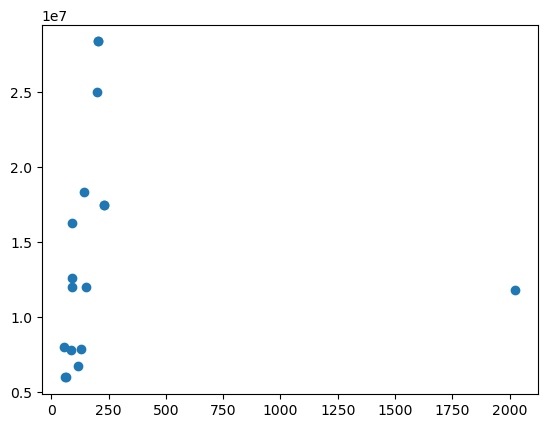

In [11]:
plt.scatter(x = df["House size"], y = df["Price"]);

## Split

In [26]:
# feature matrix
features = ["House size"]
X_train = df[features]
X_train.head()

,House size
20,203
21,230
22,203
35,150
42,90


In [27]:
# Target vector
target = "Price"
y_train = df[target]
y_train.shape

(16,)

# Build model
## Baseline

In [28]:
y_mean = y_train.mean()
y_mean

np.float64(14405343.6875)

In [29]:
y_pred_baseline = [y_mean]*len(y_train)
len(y_pred_baseline) == len(y_train)

True

## Baseline scatterplot

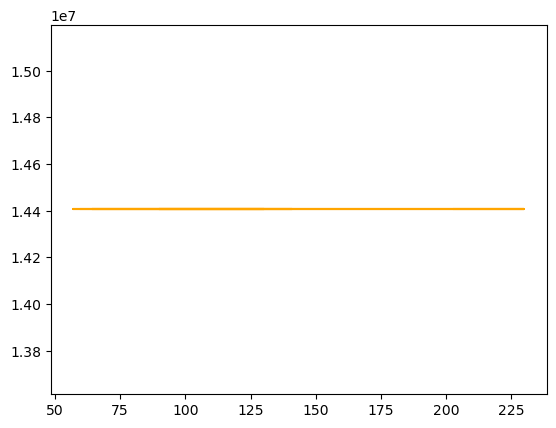

In [35]:
plt.plot(X_train, y_pred_baseline, color = "orange", label = "Baseline Model");

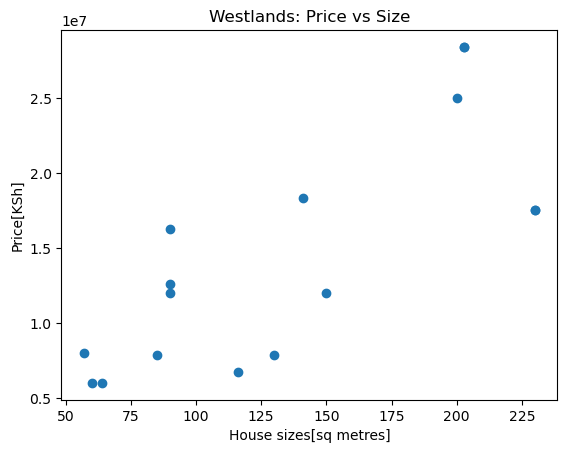

In [33]:
plt.scatter(X_train,y_train)
plt.xlabel("House sizes[sq metres]")
plt.ylabel("Price[KSh]")
plt.title("Westlands: Price vs Size");

## Baseline Mean Absolute Error

In [43]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)
print("Mean Apartment Price:",round(y_mean,2))
print("Baseline MAE:",round(mae_baseline,2))


Mean Apartment Price: 14405343.69
Baseline MAE: 6319761.65


# Iterate

In [46]:
#instantiate model
model = LinearRegression()

In [47]:
#Train model
model.fit(X_train,y_train)
#Check work
check_is_fitted(model)

# Evaluate

In [48]:
#Generate predictions
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([21043194.68958182, 23628904.00689413, 21043194.68958182,
       15967543.06670952, 10221522.36157106])

In [49]:
#Training MAE
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", round(mae_training,2))

Training MAE: 4165224.74


**Model Performance on Training Data**

The baseline model, which predicts the mean house price, resulted in a Mean Absolute Error(MAE) of **6M.**

Our trained model achieved a lower MAE of **4M**, indicating that it has successfully learned patterns in the data and outperforms the baseline.

# Generalization
## Test data using Kilimani as the location

In [67]:
df = wrangle("Nairobi propertyprices - Sheet1.csv","Kilimani")
df.head()

,Price,propertyType,Location,Bedroom,bathroom,House size,Land size
7,9500000,Apartment,Kilimani,2.0,2.0,105,NaN
15,9500000,Apartment,Kilimani,2.0,2.0,105,NaN
16,9000000,Apartment,Kilimani,2.0,2.0,90,NaN
17,7200000,Apartment,Kilimani,2.0,1.0,70,NaN
32,9000000,Apartment,Kilimani,2.0,2.0,90,NaN


In [59]:
#Feature
X_test = df[["House size"]]

#target
y_test = df["Price"]

#Predict on test data
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    1.165803e+07
1    1.165803e+07
2    1.022152e+07
3    8.306182e+06
4    1.022152e+07
dtype: float64

In [60]:
#Evaluate on testing
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Testing MAE:", round(test_mae,2))

Testing MAE: 4417992.66


## Model Evaluation Results
### Summary
**Baseline MAE**: 6319761.65

**Training MAE**: 4165224.74

**Testing MAE**: 4417992.66

### Interpretation
**The model is performing well**:

- **Both MAEs beat the baseline**: This demonstrates that house size is a useful predictor of price.
- **Test MAE is slightly higher than train MAE**: It indicates
- The model **generalizes well** to unseen data (Kilimani)
- **No overfitting** is occurring
- The model learned meaningful patterns, not just memorized the training data

### Conclusion
The model successfully predicts house prices with reasonable accuracy and shows good generalization capabilities. The slight increase in test MAE is normal and acceptable.

# Communicating Results

In [69]:
#Extract model intercept
intercept = round(model.intercept_)
intercept

1602491

In [70]:
#model coefficient
coefficient = round(model.coef_[0],2)
coefficient

np.float64(95767.01)

In [73]:
#Generate equation
print(f"apartment_price = {intercept} + {coefficient} * House size")

apartment_price = 1602491 + 95767.01 * House size


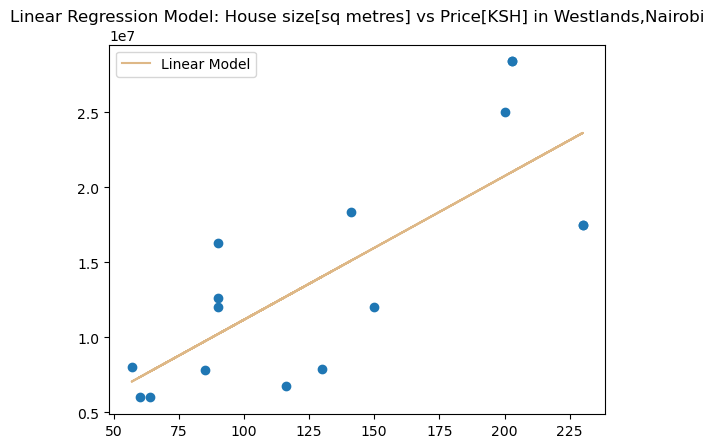

In [80]:
# Plot model
plt.plot(X_train.squeeze(), model.predict(X_train), color = "burlywood", label = "Linear Model")
plt.scatter(X_train,y_train)
plt.title("Linear Regression Model: House size[sq metres] vs Price[KSH] in Westlands,Nairobi")
plt.legend();

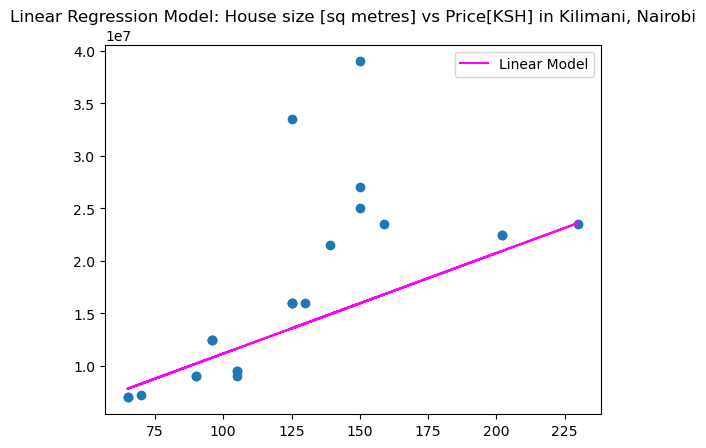

In [79]:
# Plot model
plt.plot(X_test.squeeze(), model.predict(X_test), color = "magenta", label = "Linear Model")
plt.scatter(X_test,y_test)
plt.title("Linear Regression Model: House size [sq metres] vs Price[KSH] in Kilimani, Nairobi")
plt.legend();